# Оценка эффективности нового алгоритма доставки

В сети ресторанов к вечеру падает скорость доставки из-за пересменки курьеров. data scientist-ы придумали новый алгоритм, который позволяет курьерам доставлять последние заказы "по пути" домой. Команда провела А/В тест, где одна часть курьеров использует старый алгоритм, а другая - новый. \
**Задача.** Необходимо проанализировать данные эксперимента и помочь принять решение об эффективности нового алгоритма.

**Описание данных**
order_id - id заказа\
delivery_time - время доставки в минутах\
district - район доставки\
experiment_group - экспериментальная группа

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import pingouin as pg

In [2]:
df = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/experiment_lesson_4.csv')
df.sample(3)

,order_id,delivery_time,district,experiment_group
19548,18384,42.0,Purlieus,test
15184,18867,35.0,Purlieus,test
17093,17207,39.0,Purlieus,test


In [3]:
df.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [6]:
df.groupby('experiment_group').count()

,order_id,delivery_time,district
experiment_group,,,
control,10092,10092,10092
test,10104,10104,10104


Дубликатов и пропусков нет. Типы данных соответсвуют заявленным. Количество наблюдений в группах практически одинаково.

**Гипотезы.** \
Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.\
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть.

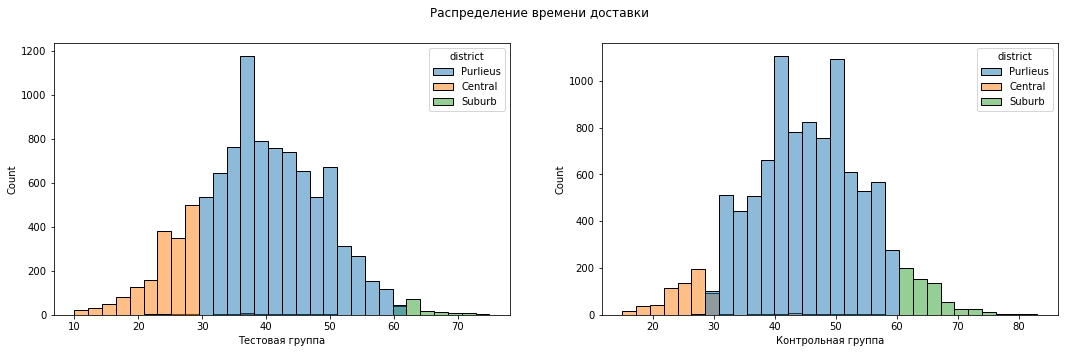

In [7]:
test = df.query("experiment_group == 'test'")
control = df.query("experiment_group == 'control'")

fig, ax = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle('Распределение времени доставки')
sns.histplot(test, x='delivery_time', hue='district', bins=30, ax=ax[0])
sns.histplot(control, x='delivery_time', hue='district', bins=30, ax=ax[1])
ax[0].set_xlabel("Тестовая группа")
ax[1].set_xlabel("Контрольная группа")
plt.show()

Форма распределения нормальна в обоих группах. В отсутствие слишком выраженной асимметрии и выбросов в данных t-тест и так должен работать нормально, но можно посмотреть на всякий случай.

In [8]:
pg.normality(df, dv='delivery_time', group='experiment_group', method='normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


Несмотря на то, что тестовая группа распределена ненормально по тестам, это не являет причиной не использовать т-тест.

In [9]:
scipy.stats.ttest_ind(df[df['experiment_group'] == 'test']['delivery_time'], 
                      df[df['experiment_group'] == 'control']['delivery_time'])

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [10]:
average_time = df.groupby('experiment_group', as_index = False).agg({'delivery_time':'mean'})
average_time

,experiment_group,delivery_time
0,control,45.065101
1,test,39.046813


In [11]:
abs(round((average_time['delivery_time'][1]-average_time['delivery_time'][0])/average_time['delivery_time'][0]*100, 1))

13.4

**Вывод:** Средние двух групп статистичестки значимо отличаются. Время доставки в тестовой группе уменьшилось в среднем на 6 минут, это более 13%. По итогу теста можно распространить новый алгоритм на всех курьеров.